In [16]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [6]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [11]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix CHANGE
    hv = HashingVectorizer(n_features=2 ** 10, alternate_sign=False,stop_words='english')
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html CHANGE
    transformer = TfidfTransformer() #inside of this () change
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.1, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [12]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=42)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [15]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 14650, 'Neg': 128963, 'TP': 6233, 'TN': 126109, 'FP': 2854, 'FN': 8417, 'Accuracy': 0.9215182469553592, 'Precision': 0.6859249477275229, 'Recall': 0.4254607508532423, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [26]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 14650, 'Neg': 128963, 'TP': 6356, 'TN': 125738, 'FP': 3225, 'FN': 8294, 'Accuracy': 0.9197913837883757, 'Precision': 0.6633963051873499, 'Recall': 0.43385665529010237, 'desc': 'svm_train'}


### MODEL: logistic regression

In [27]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 14650, 'Neg': 128963, 'TP': 6161, 'TN': 125934, 'FP': 3029, 'FN': 8489, 'Accuracy': 0.9197983469463071, 'Precision': 0.6704026115342764, 'Recall': 0.4205460750853242, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 14650, 'Neg': 128963, 'TP': 10685, 'TN': 110923, 'FP': 18040, 'FN': 3965, 'Accuracy': 0.8467757097198721, 'Precision': 0.37197563098346387, 'Recall': 0.7293515358361775, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [29]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 14650, 'Neg': 128963, 'TP': 6493, 'TN': 124096, 'FP': 4867, 'FN': 8157, 'Accuracy': 0.9093118311016413, 'Precision': 0.5715669014084507, 'Recall': 0.44320819112627985, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [30]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 14650, 'Neg': 128963, 'TP': 4097, 'TN': 128404, 'FP': 559, 'FN': 10553, 'Accuracy': 0.9226253890664494, 'Precision': 0.8799398625429553, 'Recall': 0.27965870307167234, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 14650, 'Neg': 128963, 'TP': 0, 'TN': 128963, 'FP': 0, 'FN': 14650, 'Accuracy': 0.8979897363052092, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/sarahlee/Downloads/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

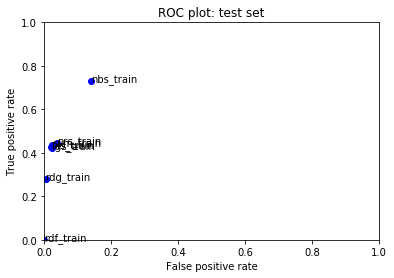

In [32]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [33]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [34]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
529
Sorry. Ed just makes it so easy. I don't know why he thinks he's above throwing poop. 68.203.13.249
* * * * * * * * * 
2044
Gah, I suspected that this guy had at least some experience, knowing what BLPs were and all that. I don't see anything in the block log, am I looking in the wrong place? He seems bent on my protection rationale - not the best, but hey - even though it would've been protected for a BLP dispute anyways. Keilana|Parlez ici 

Is that the right IP address? I don't see a block in the log. If you're right, then it's a sock getting around a block to harasss an admin... Dreadstar †  
Frak; I don't see it now; maybe I looked at the wrong tab? Sorry, folks, I may have cried wolf on this one. Pairadox (talk)  
It's alright, I've got a coupla messes on my hands, if you find it that would be great, if not, it's no big deal. He said it'd be his last post on my talk, so it may have just sorted itself out, without unnecessary drama. Thank God. Keil

33424
"

 Okay well, this summary sucks in general but.. 

” In the Swan hatch, Juliet checks the security cameras and finds Kate, Sawyer, and Alex outside the Dharma facility where Karl is being held captive.""

This is 100% not the swan hatch. 
http://en.wikipedia.org/wiki/DHARMA_Initiative_stations"
* * * * * * * * * 
34586
"
I've removed the unjustified block on you. I hope that what you take away from this incident is a good laugh. Behold the self-fulfilling edit summary. )  / ɹəədsɹ  "
* * * * * * * * * 
37746
@ no hard feelings dude, this happens every time I revert someone's pov edits. Why don't you give WP:OR and WP:SYNTH a read while the ANI goes through? Believe me, you wont spend more than 20 minutes reading them, and your editing perspective may change drastically seeing what wikipedia does not allow.
* * * * * * * * * 
38499
"

You said yourself there was no consensus. I said there was and I was correct. And the other person ""blew me out of the water""? I can dig up hund

72863
Madness  hey, yo! -)
* * * * * * * * * 
74580
"Haunted Angel I have agreed to leave you alone so dont ban me. I havent
posted once since I said ""I will leave you alone and stop bothering. I
hope you will one day see the light."" Since I have not posted here  

"
* * * * * * * * * 
77051
why the Norse were unsuccessful in Greenland
* * * * * * * * * 
77943
I'm commenting on your observable actions (your manipulation and abuse of procedure), not speculating on your internal motivation. 61.68.175.113
* * * * * * * * * 
78519
Hey great job on finding out who I am typer525. You're a modern day Sherlock Holmes. The hero of Whitney Highschools wikipedia page. Hooray! So when am I going to receive your email? -Karl )
* * * * * * * * * 
79256
Smart Man 

You are smart man but I ask you not to be rude but why believe in God? With all knowledge you that have why believe you in something with no scientific backink.
* * * * * * * * * 
80559
I see that you have blocked me.
I presume you did n

109052
Hmmmmm.  I think you may have tipped your hand by reverting to old form here....
* * * * * * * * * 
111023
How about this one, which does both: . It even calls them Juggalos in the headline.
* * * * * * * * * 
111240
Watching my every move is harassment, maybe not according to wikipedia but it is still harassment. I am very new at wikipedia and I make mistakes and people like you are not very helpful and are extremely annoying by stalking me. Just leave me alone Gdo01, stop stalking me, stop talking to me (Unless I vandalize something), and just leave me alone. I did not know you could not have more than one account, big deal, I am only 16 and very new at wikipedia but I get it now, so will you just leave me alone? Please? It would be much appreciated. User:Daniel Chiswick 9 May, 2007.
* * * * * * * * * 
111985
Rms125a@hotmail.com's vandalism 

This article has been repeatedly vandalised by Rms125a@hotmail.com. who appears from this and other discussions to be an obsessive compu

125024
I honestly don't care anymore to argue for YouTube or not, this has gone off-topic because a certain troll has decided to remove any criticism he gets for bothering me. I'm not answering anything until my original messages which he removed are restored. This user has been doing this since this morning.  
First of all you removed reliable things. 2 your the troll who is start to personal attack me meaning i have dyslexia and your making fun of me b/c of that, and if you can read which I know you can it has been stated 400 times that the video is not youtub it is Nintendo. 

I have read enough, I'm not going to play your troll game. This is a waste of time and space. I'm not promoting your attitude and stalker behavior and I'm asking someone else to remove this seeing as this is jut a personal play area for DeityLink to harass and troll me.
* * * * * * * * * 
126571
"

According to those SPI notices: I am the SockMaster, and experienced users, Administrators and Check Users are my

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [35]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 638, 'TN': 14039, 'FP': 344, 'FN': 937, 'Accuracy': 0.9197267828048628, 'Precision': 0.6496945010183299, 'Recall': 0.4050793650793651, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [36]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 645, 'TN': 13983, 'FP': 400, 'FN': 930, 'Accuracy': 0.9166562225842837, 'Precision': 0.6172248803827751, 'Recall': 0.4095238095238095, 'desc': 'svm_test'}


### MODEL: logistic regression

In [37]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 625, 'TN': 14022, 'FP': 361, 'FN': 950, 'Accuracy': 0.9178468479759369, 'Precision': 0.6338742393509128, 'Recall': 0.3968253968253968, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [38]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 1118, 'TN': 12310, 'FP': 2073, 'FN': 457, 'Accuracy': 0.8414588294272465, 'Precision': 0.35036038859291757, 'Recall': 0.7098412698412698, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [39]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 655, 'TN': 13798, 'FP': 585, 'FN': 920, 'Accuracy': 0.9056899360822158, 'Precision': 0.5282258064516129, 'Recall': 0.4158730158730159, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [40]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 418, 'TN': 14317, 'FP': 66, 'FN': 1157, 'Accuracy': 0.9233613234741196, 'Precision': 0.8636363636363636, 'Recall': 0.2653968253968254, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [41]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 1575, 'Neg': 14383, 'TP': 0, 'TN': 14383, 'FP': 0, 'FN': 1575, 'Accuracy': 0.9013034214813886, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

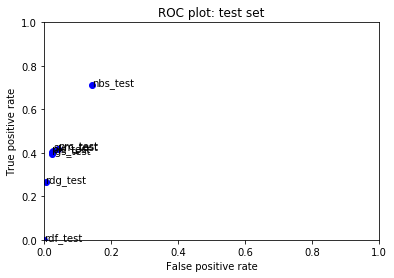

In [42]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [43]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=48, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1024)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6         

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [45]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nbs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.2512078556318717


In [46]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [47]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [48]:
my_submission.shape

(153164, 2)

In [49]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation

In [53]:
my_submission.to_csv('toxiccomments_submission.csv', index=False)

In [ ]:
my_submission.to_csv('toxiccomments_submission.csv', index=False)